In [1]:
# Reference:
#     gpflow: https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
#             https://github.com/GPflow/GPflow/blob/develop/gpflow/models/sgpr.py#L263
#     julia:  https://github.com/STOR-i/GaussianProcesses.jl/blob/master/src/sparse/fully_indep_train_conditional.jl
#     ladax:  https://github.com/danieljtait/ladax
#
import numpy as np
import numpy.random as npr
from numpy.linalg import inv, det, cholesky
from numpy.linalg import solve as backsolve
np.set_printoptions(precision=3,suppress=True)
from sklearn.metrics import mean_squared_error

import jax
from jax import grad, jit, vmap, device_put
import jax.numpy as jnp
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')

from tabulate import tabulate

import sys
sys.path.append('../kernel')
from jaxkern import (cov_se, cov_rq, cov_pe, LookupKernel, normalize_K, mtgp_k)

from plt_utils import plt_savefig, plt_scaled_colobar_ax
from gp import gp_regression_chol, run_sgd, log_func_default, log_func_simple, flax_run_optim


(-2.0, 2.0)

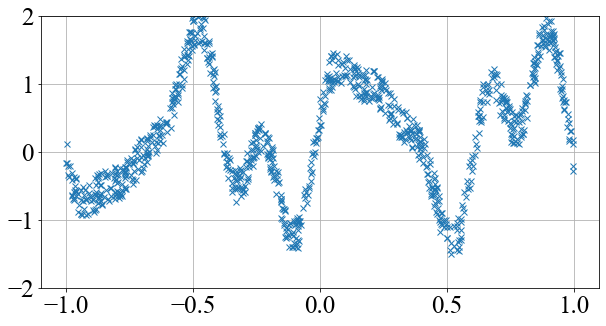

In [61]:

## Parameters 

xlim = (-1, 1)
ylim = (-2, 2)
n_train = 1000
n_test = 200
σn = .5
logsn = np.log(σn)
lr = .01
num_steps = 20


## Data

def f_gen(x):
    return np.sin(x * 3 * 3.14) + \
           0.3 * np.cos(x * 9 * 3.14) + \
           0.5 * np.sin(x * 7 * 3.14)

## Plotting

npr.seed(0)
X_train = np.expand_dims(npr.uniform(xlim[0], xlim[1], size=n_train), 1)
y_train = f_gen(X_train) + σn * npr.rand(n_train, 1)
data = (X_train, y_train)
X_test  = np.expand_dims(np.linspace(*xlim, n_test), 1)


fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(X_train, y_train, 'x', alpha=1)
ax.grid()
ax.set_ylim(ylim)

In [96]:
from typing import Any, Callable, Sequence, Optional, Tuple

import jax
import jax.numpy as np
import jax.numpy.linalg as linalg

import flax
from flax import linen as nn

from jaxkern import cov_se


class CovSE(nn.Module):
    
    def setup(self):
        init_fn = nn.initializers.zeros
        self.logℓ = self.param('logℓ', init_fn, (1,))
        self.logσ = self.param('logσ', init_fn, (1,))

    def __call__(self, X, Y=None):
        return cov_se(X, Y, logℓ=self.logℓ, logσ=self.logσ)


    
class Gpr(nn.Module):
    data: Tuple[np.ndarray, np.ndarray]
        
    def setup(self):
        self.k = CovSE()
        self.logσn = self.param('logσn', nn.initializers.zeros, (1,))
        
    def get_init_params(self, key):
        params = self.init(key, np.ones((1, self.data[0].shape[-1])),
                           method=self.pred_f)['params']
        return params

    def mll(self):
        X, y = self.data
        k = self.k
        n = len(X)
        σ2 = np.exp(2*self.logσn)
        
        K = k(X, X) + σ2*np.eye(n)
        L = linalg.cholesky(K)
        α = linalg.solve(L.T, linalg.solve(L, y))

        mll_quad  = -(1/2)*np.sum(y*α)
        mll_det   = - np.sum(np.log(np.diag(L)))
        mll_const = - (n/2)*np.log(2*np.pi)
        mll = mll_quad + mll_det + mll_const

        return mll
    
    def pred_f(self, Xs):
        X, y = self.data
        k = self.k
        n = len(X)
        σ2 = np.exp(2*self.logσn)
        
        K = k(X, X) + σ2*np.eye(n)
        Ks = k(X, Xs)
        Kss = k(Xs, Xs)
        L = linalg.cholesky(K)
        α = linalg.solve(L.T, linalg.solve(L, y))
        μ = Ks.T@α
        v = linalg.inv(L)@Ks
        Σ = Kss - v.T@v
        
        return μ, Σ
    
    def pred_y(self, Xs):
        σ2 = np.exp(2*self.logσn)
        μf, Σf = self.pred_f(Xs)
        ns = len(Σf)
        μy, Σy = μf, Σf + σ2*np.diag(np.ones((ns,)))
        return μy, Σy
        


In [97]:


lr = .001
num_steps = 50



model = Gpr(data)
params = model.get_init_params(key)
nmll = lambda params: -model.apply({'params': params}, method=model.mll)
params = flax_run_optim(nmll, params, lr=lr,
                        num_steps=num_steps, log_func=log_func)






[  0]	Loss=1213.767	σn=1.000
[  1]	Loss=1160.233	σn=0.641
[  2]	Loss=1165.608	σn=0.889
[  3]	Loss=1150.097	σn=0.655
[  4]	Loss=1153.393	σn=0.857
[  5]	Loss=1144.663	σn=0.665
[  6]	Loss=1146.643	σn=0.837
[  7]	Loss=1140.734	σn=0.672
[  8]	Loss=1141.635	σn=0.822
[  9]	Loss=1136.885	σn=0.677
[ 10]	Loss=1136.195	σn=0.807
[ 11]	Loss=1129.966	σn=0.679
[ 12]	Loss=1121.476	σn=0.787
[ 13]	Loss=1086.476	σn=0.667
[ 14]	Loss=895.549	σn=0.709
[ 15]	Loss=530.647	σn=0.422
[ 16]	Loss=36.691	σn=0.347
[ 17]	Loss=-389.024	σn=0.158
[ 18]	Loss=-389.632	σn=0.144
[ 19]	Loss=-389.683	σn=0.157
[ 20]	Loss=-390.111	σn=0.144
[ 21]	Loss=-390.177	σn=0.156
[ 22]	Loss=-390.495	σn=0.145
[ 23]	Loss=-390.562	σn=0.155
[ 24]	Loss=-390.807	σn=0.145
[ 25]	Loss=-390.878	σn=0.154
[ 26]	Loss=-391.055	σn=0.146
[ 27]	Loss=-391.120	σn=0.154
[ 28]	Loss=-391.258	σn=0.146
[ 29]	Loss=-391.318	σn=0.153
[ 30]	Loss=-391.442	σn=0.147
[ 31]	Loss=-391.490	σn=0.153
[ 32]	Loss=-391.581	σn=0.147
[ 33]	Loss=-391.635	σn=0.153
[ 34]	Loss=-391.71

Text(0.5, 1.0, '$-\\log p(\\mathbf{y}\\mid X)$=-392.28')

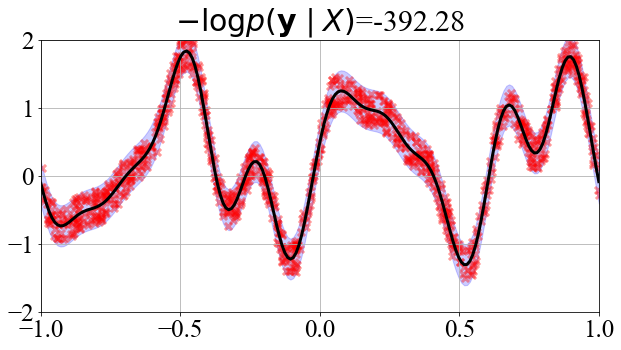

In [112]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

model = Gpr(data)
mll = model.apply({'params': params}, method=model.mll)
μ, Σ = model.apply({'params': params}, X_test, method=model.pred_y)
std = np.expand_dims(np.sqrt(np.diag(Σ)), 1)

ax = axs
ax.plot(X_test, μ, color='k')
ax.fill_between(X_test.squeeze(), (μ-2*std).squeeze(), (μ+2*std).squeeze(), alpha=.2, color=cmap(0))
ax.scatter(X_train, y_train, marker='x', color='r', s=50, alpha=.4)
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('$-\log p(\mathbf{y}\mid X)$'+f'={-mll:.2f}')

In [82]:
F = npr.randn(3,3)
F

array([[-0.403,  0.949, -0.163],
       [-0.086, -0.43 ,  1.149],
       [ 0.298,  0.044,  0.643]])

In [91]:
F+np.diag(np.ones((len(F),)))

DeviceArray([[ 0.597,  0.949, -0.163],
             [-0.086,  0.57 ,  1.149],
             [ 0.298,  0.044,  1.643]], dtype=float32)